In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV, VOCDetectionFromLMDB
from torchlake.object_detection.models.yolov1_tiny import YOLOV1Tiny
from torchlake.object_detection.models.yolov1 import YOLOLoss
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.plot import draw_pred
from torchlake.object_detection.utils.train import collate_fn
from torchlake.common.controller.trainer import DoNothingTrainer

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path

# setting

In [3]:
artifact_path = Path('../../artifacts/yolov1/tiny')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = 2

In [6]:
CONTEXT = DetectorContext(
    detector_name="yolov1-tiny",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
)

# data

In [7]:
BATCH_SIZE = 32

In [8]:
IMAGE_SIZE = 448

In [9]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.augmentations.geometric.resize.SmallestMaxSize(input_size),
        # A.RandomSizedBBoxSafeCrop(input_size, input_size),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [10]:
# train_dataset = VOCDetectionFromCSV(
#     data_path,
#     data_path.joinpath("voc_trainval.csv"),
#     transform=transform,
# )

In [11]:
train_dataset = VOCDetectionFromLMDB(
    "../../data/VOCdevkit/voc",
    transform=transform,
)

In [12]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 448, 448]) 1


In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [14]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([32, 3, 448, 448]) 32


# model

In [15]:
model = YOLOV1Tiny(CONTEXT).to(CONTEXT.device)

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
YOLOV1Tiny                               --
├─Sequential: 1-1                        --
│    └─Conv2dNormActivation: 2-1         --
│    │    └─Conv2d: 3-1                  432
│    │    └─BatchNorm2d: 3-2             32
│    │    └─LeakyReLU: 3-3               --
│    └─MaxPool2d: 2-2                    --
├─Sequential: 1-2                        --
│    └─Conv2dNormActivation: 2-3         --
│    │    └─Conv2d: 3-4                  4,608
│    │    └─BatchNorm2d: 3-5             64
│    │    └─LeakyReLU: 3-6               --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2dNormActivation: 2-5         --
│    │    └─Conv2d: 3-7                  18,432
│    │    └─BatchNorm2d: 3-8             128
│    │    └─LeakyReLU: 3-9               --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2dNormActivation: 2-7         --
│    │    └─Conv2d: 3-10                 73,728
│    │    └─BatchNorm2d: 3-11            256
│    │    └─L

# train

In [ ]:
EPOCH = 20

In [18]:
trainer = DoNothingTrainer(EPOCH, CONTEXT.device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = YOLOLoss(CONTEXT, lambda_coord=5, lambda_noobject=0.5)

In [20]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [38]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 517/517 [02:19<00:00,  3.70it/s]


epoch 1 : 2.9930744127332587 (0%)


100%|██████████| 517/517 [02:16<00:00,  3.78it/s]


epoch 2 : 2.9472128980625527 (-2%)


100%|██████████| 517/517 [02:24<00:00,  3.57it/s]


epoch 3 : 2.8891222191041397 (-2%)


100%|██████████| 517/517 [02:36<00:00,  3.31it/s]


epoch 4 : 2.8792000612391724 (0%)


100%|██████████| 517/517 [02:19<00:00,  3.71it/s]


epoch 5 : 2.8538061938387282 (-1%)


100%|██████████| 517/517 [02:12<00:00,  3.91it/s]


epoch 6 : 2.8287862124249368 (-1%)


100%|██████████| 517/517 [02:11<00:00,  3.92it/s]


epoch 7 : 2.779814284820852 (-2%)


100%|██████████| 517/517 [02:11<00:00,  3.95it/s]


epoch 8 : 2.75230840234738 (-1%)


100%|██████████| 517/517 [02:11<00:00,  3.92it/s]


epoch 9 : 2.744759451951003 (0%)


100%|██████████| 517/517 [02:12<00:00,  3.90it/s]

epoch 10 : 2.7303952691172264 (-1%)


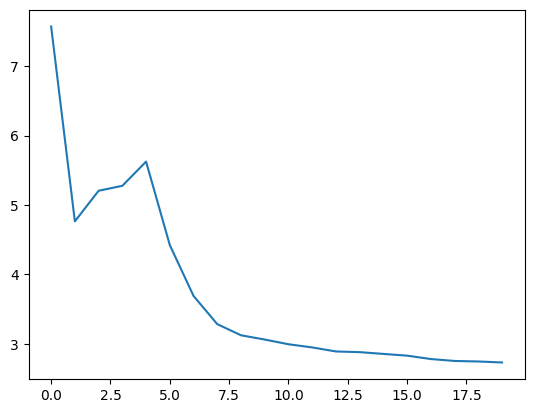

In [40]:
plt.plot(training_loss)

In [41]:
model_path = artifact_path / f'yolov1.tiny.20.pth'

In [42]:
torch.save(model.state_dict(), model_path)

In [43]:
get_file_size(model_path)

'103.39MiB'

In [26]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# inference

In [48]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [49]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [50]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [51]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [52]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [53]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [54]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [55]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [56]:
model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B, C+1, H, W
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/155 [00:01<?, ?it/s]


In [57]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

person: 0.10
person: 0.11
person: 0.12
aeroplane: 0.10
person: 0.12


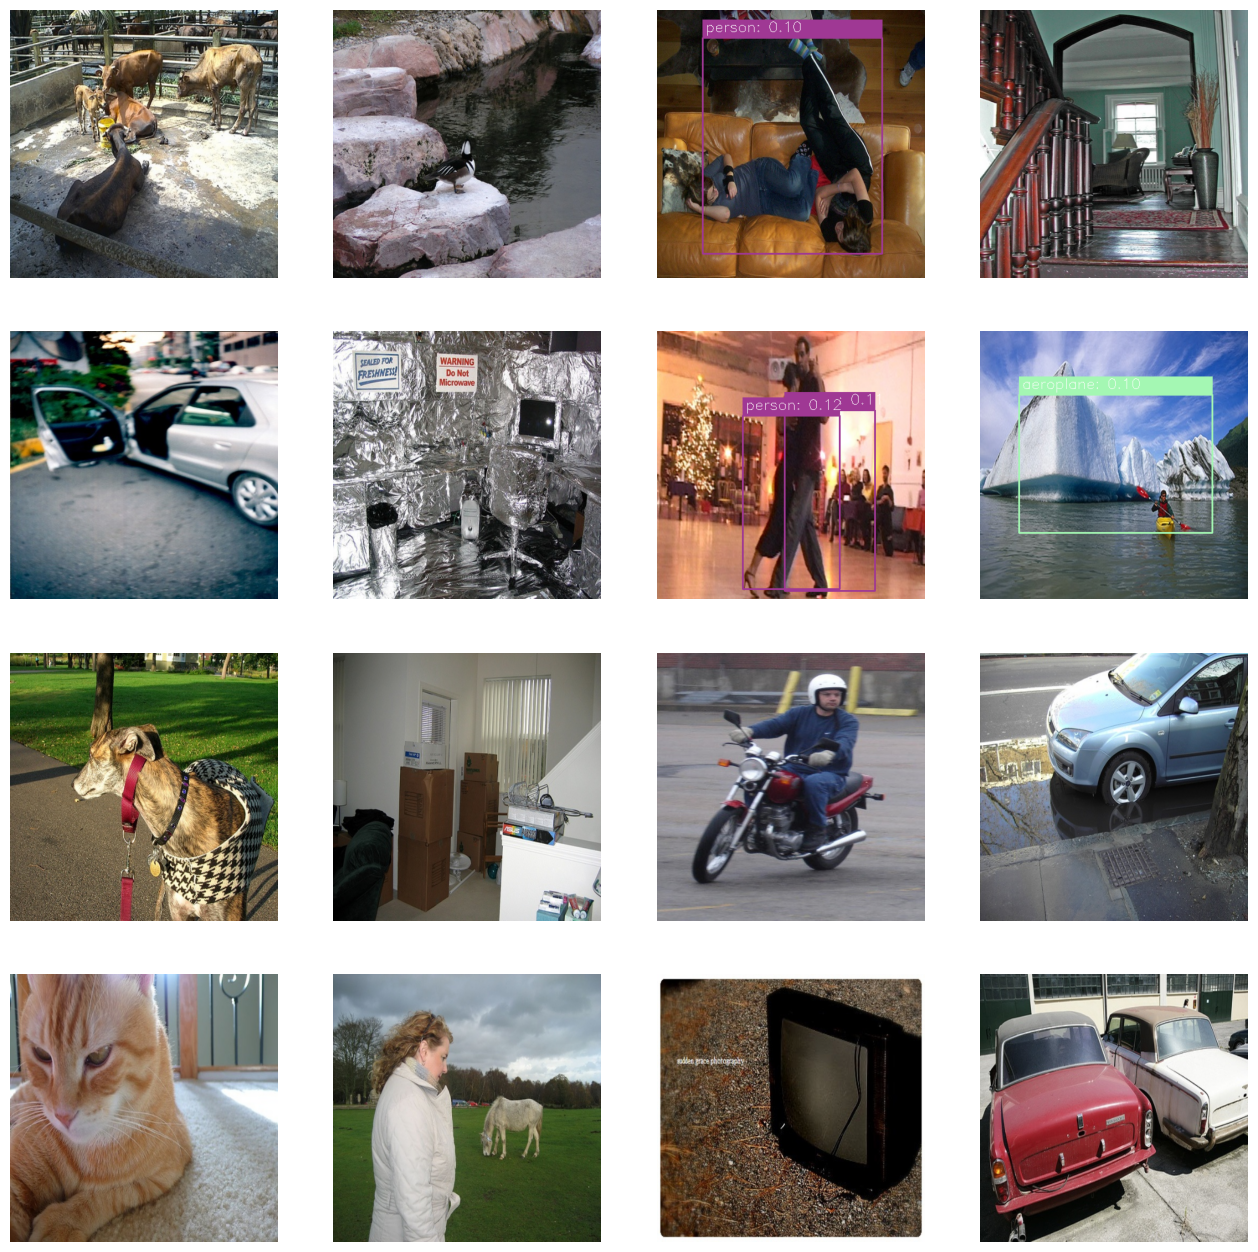

In [58]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [68]:
humans_img = "D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg 0
D://W/hmm/Screenshot_20240612_091521.jpg 0
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 0


In [ ]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

# evaluation

In [59]:
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [60]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [61]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [62]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [63]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [64]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [65]:
evaluator = Evaluator(CONTEXT)

In [66]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 155/155 [03:17<00:00,  1.28s/it]

       aeroplane   bicycle      bird      boat    bottle       bus       car  \
AP@0.5  0.049587  0.049587  0.049587  0.049587  0.049587  0.056818  0.090909   

             cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.090909  0.090909  0.090909  ...  0.090909  0.090909  0.090909   

         person pottedplant    sheep     sofa    train tvmonitor      all  
AP@0.5  0.05303     0.05303  0.05303  0.05303  0.05303   0.05303  0.06751  

[1 rows x 21 columns]


In [67]:
result_table.T

,AP@0.5
aeroplane,0.049587
bicycle,0.049587
bird,0.049587
boat,0.049587
bottle,0.049587
bus,0.056818
car,0.090909
cat,0.090909
chair,0.090909
cow,0.090909


In [ ]:
for path in artifact_path.joinpath(evaluator.cfg.MODEL.BACKBONE).glob("*.pth"):
    model.load_state_dict(torch.load(path))

    evaluator.run(
        predictor,
        model,
        test_loader,
        VOC_CLASS_NAMES,
        save_dir=artifact_path.as_posix(),
        output_filename=f"{path.stem}.eval.csv",
    )